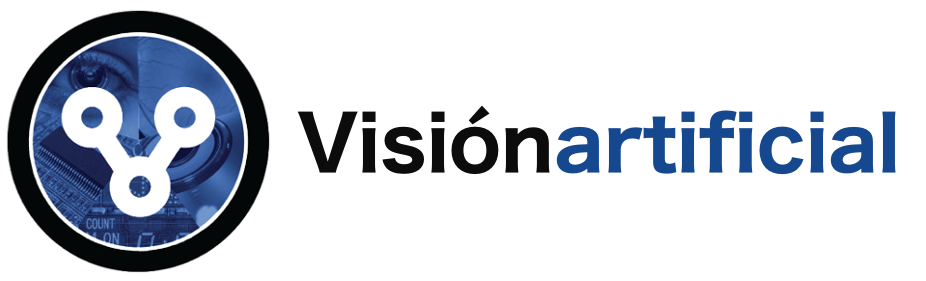

# OpenCV 

### para a materia de Visión Artificial do Grao de Robótica. EPSE de Lugo.

<hr style = "border: none; height: 4px; background-color: # D3D3D3" />

# <font style="color:rgb(50,120,229)">API de Seguimento de obxectos en OpenCV</font>

# <font style="color:rgb(50,120,229)">API de seguimento en OpenCV 4</font>


OpenCV 4 inclúe unha nova API de seguimento que contén implementacións de moitos algoritmos de seguimento de obxectos únicos. Hai 8 rastreadores diferentes dispoñibles en OpenCV 4.1.0+

1. BOOSTING, 

2. Multiple Instance Learning ( MIL ) 

3. Kernelized Correlation Filters (KCF) 

4. Tracking, learning and detection (TLD) 

5. MEDIANFLOW

6. GOTURN (Deep Learning based)

7. MOSSE

8. CSRT 



Agora explicaremos varios algoritmos de seguimento implementados en OpenCV e un exemplo de como usalos.

# <font style="color:rgb(50,120,229)">Algoritmos de seguimento de obxectos</font>


Nesta sección, afondaremos un pouco en diferentes algoritmos de seguimento. O obxectivo non é ter unha profunda comprensión teórica de cada rastreador, senón entendelos desde un punto de vista práctico.

Comecemos explicando primeiro algúns principios xerais detrás do seguimento. Neste eido, o noso obxectivo é atopar un obxecto no fotograma actual dado que rastrexamos o obxecto con éxito en todos (ou case todos) os fotogramas anteriores.

Xa que rastrexamos o obxecto ata o frame actual, sabemos como se moveu. Noutras palabras, coñecemos os parámetros do **modelo de movemento** que é só unha forma elegante de dicir que coñeces a localización e a velocidade (velocidade + dirección do movemento) do obxecto en fotogramas anteriores. Se non soubeses nada máis sobre o obxecto, poderías predecir a nova localización baseándose no modelo de movemento actual e estarías moi preto de onde está a nova localización do obxecto. Usamos este enfoque ao describir o filtro de Kalman.

Pero temos máis información que só o movemento do obxecto. Sabemos como se ve o obxecto en cada un dos fotogramas anteriores. Noutras palabras, podemos construír un **modelo de aparencia** que codifique o aspecto do obxecto. Este modelo de aparencia pódese usar para buscar nunha pequena veciñanza da localización prevista polo modelo de movemento para predecir con máis precisión a localización do obxecto.

O modelo de movemento predice a localización aproximada do obxecto. O modelo de aparencia afina esta estimación para proporcionar unha aproximación máis precisa.

Se o obxecto é moi sinxelo e non cambiase moito a súa aparencia, o modelo de aparencia podería ser simple. Non obstante, a vida real as cousas non son tan fáciles dado que a súa aparencia pode cambiar drasticamente. Para solucionar este problema, en moitos seguidores modernos, o modelo de aparencia é un **clasificador** que se adestra de forma **en liña**. Expliquemos isto en termos máis sinxelos.

Como sabemos de temas anteriores, o traballo dun clasificador é discernir se unha rexión rectangular dunha imaxe é obxecto ou fondo. O clasificador toma un parche da imaxe como entrada e devolve unha puntuación entre 0 e 1 para indicar a probabilidade de que o parche de imaxe conteña o obxecto. A puntuación é 0 cando está absolutamente seguro de que o parche da imaxe é o fondo e 1 cando está absolutamente seguro de que o parche é o obxecto.

Cando adestramos o noso propio clasificador, podemos pasar horas de cálculo para adestrarlo. Durante o seguimento non temos ese tempo. Na aprendizaxe automática, usamos a palabra "en liña" para referirnos a algoritmos que se adestran sobre a marcha durante o tempo de execución. Un clasificador *fóra de liña* pode necesitar miles de exemplos para adestrarse, pero un clasificador *en liña* adoita ser adestrado usando moi poucos exemplos no tempo de execución.

Un clasificador adestrase dándolle exemplos positivos (obxecto) e negativos (fondo). Se queres construír un clasificador para detectar gatos, adestras con miles de imaxes que conteñen gatos e miles de imaxes que non conteñen gatos. Deste xeito o clasificador aprende a diferenciar o que é un gato e o que non.

Vexamos como os diferentes algoritmos de seguimento abordan este problema da adestramento en liña.



## <font style="color:rgb(50,120,229)">BOOSTING Tracker</font>

Este seguidor está baseado nunha versión en liña de AdaBoost, o algoritmo que usa internamente o detector facial baseado en cascada de HAAR. Este clasificador debe ser adestrado en tempo de execución con exemplos positivos e negativos do obxecto. O rectángulo delimitador inicial proporcionado polo usuario (ou por outro algoritmo de detección de obxectos) tómase como exemplo positivo para o obxecto, e moitos parches de imaxe fóra do marco delimitador son tratados como fondo. Dado unha nova caixa, o clasificador execútase en cada píxel da contorna da localización anterior e rexístrase a puntuación. A nova localización do obxecto é aquela onde a puntuación é máxima. Entón, agora temos un exemplo positivo máis para o clasificador. A medida que chegan máis fotogramas, o clasificador actualízase con estes datos adicionais.

**Pros**: Ningún. Este algoritmo ten unha década de antigüidade e funciona ben, pero non puiden atopar unha boa razón para usalo, especialmente cando hai dispoñibles outros rastreadores avanzados (MIL, KCF) baseados en principios similares.

**Contra**: o rendemento do seguimento é mediocre. Non sabe de forma fiable cando fallou o seguimento.



## <font style="color:rgb(50,120,229)">MIL Tracker</font>

Este rastreador é semellante en idea ao rastreador BOOSTING descrito anteriormente. A gran diferenza é que, en lugar de considerar só a localización actual do obxecto como un exemplo positivo, busca nunha pequena veciñanza ao arredor da localización actual para xerar varios posibles exemplos positivos. Podes estar pensando que é unha mala idea porque na maioría destes exemplos "positivos" o obxecto non está centrado.

Aquí é onde a aprendizaxe de instancias múltiples (MIL) chega ao rescate. En MIL, non especificas exemplos positivos e negativos, senón "bolsas" positivas e negativas. A bolsa é etiquetada como positiva se algunha das instancias da bolsa está etiquetada como positiva polo clasificador. En caso contrario, a bolsa está etiquetada como negativa.

**Pros**: o rendemento é bastante bo e fai un traballo razoable baixo oclusión parcial.

**Contra**: o fallo de seguimento non se informa de forma fiable. Non se recupera da oclusión total.



## <font style="color:rgb(50,120,229)">KCF Tracker</font>

KCF significa **Kernelized Correlation Filters**. Este rastreador baséase nas ideas presentadas nos dous rastreadores anteriores. Utiliza o feito de que as múltiples mostras positivas utilizadas en MIL teñen grandes rexións superpostas que dan lugar a unhas boas propiedades matemáticas que aproveita para facer o seguimento máis rápido e máis preciso ao mesmo tempo.

**Pros**: a precisión e a velocidade son mellores que MIL e informa de fallos de seguimento mellor que BOOSTING e MIL.

**Contras** : non se recupera da oclusión total.

## <font style="color:rgb(50,120,229)">TLD Tracker</font>

TLD significa **Rastrexo, aprendizaxe e detección**. Como o nome indica, este rastreador descompón a tarefa de seguimento en tres compoñentes: seguimento (curto prazo), aprendizaxe e detección. Do artigo do autor: "O rastreador segue o obxecto de fotograma a fotograma, localizando todas as aparencias que se observaron ata agora e corrixese  se é necesario. A aprendizaxe estima os erros do detector e actualízao para evitalos no futuro." 
A saída deste seguidor tende a saltar un pouco. Por exemplo, se estás rastrexando un peón e hai outros na escena, pode seguir temporalmente a outro peón diferente ao que pretendía. No lado positivo, este tracker parece seguir un obxecto ante variación máis fortes na escala, movemento e oclusión. Se tes unha secuencia de vídeo onde o obxecto está oculto detrás doutro obxecto, este método pode ser unha boa opción.

**Pros**: funciona o mellor baixo oclusión en varios fotogramas. Ademais, segue mellor os cambios de escala.

**Contras**: moitos falsos positivos que o fan case inutilizable.




## <font style="color:rgb(50,120,229)">MEDIANFLOW Tracker</font>

Internamente, este este método segue ao obxecto no tempo en dirección cara adiante e cara atrás e mide as discrepancias entre estas dúas traxectorias. Minimizar este erro "ForwardBackward" permítelles detectar de forma fiable os fallos de seguimento e seleccionar traxectorias fiables nas secuencias de vídeo.

Nas nosas probas, descubrimos que este rastreador funciona mellor cando o movemento é previsible e pequeno. A diferenza doutros rastreadores que seguen funcionando mesmo cando o seguimento fallou claramente, este rastreador sabe cando fallou o seguimento.

**Pros**: excelente informe de erros de seguimento. Funciona moi ben cando o movemento é previsible e non hai oclusión.

**Contra**: falla con grandes movementos.

## <font style="color:rgb(50,120,229)">GOTURN tracker</font>

De todos os algoritmos de seguimento desta clase, este é o único baseado en redes neuronais convolucionais (CNN). Tamén é o único que usa un modelo adestrado fóra de liña, polo que é máis rápido ca outros rastreadores. Pola documentación de OpenCV, sabemos que é "robusto para os cambios de punto de vista, os cambios de iluminación e as deformacións". Pero non manexa moi ben a oclusión.

<font style="color:rgb(200,0,0)">**NOTA:**</font> GOTURN, sendo un rastreador baseado na CNN, usa un modelo cafe para o seguimento. O modelo Caffe e o ficheiro prototxt deben estar no directorio onde se esté executanto este código.



## <font style="color:rgb(50,120,229)">MOSSE tracker</font>

A idea de usar filtros de correlación para o seguimento é moi antiga. Non obstante, se simplemente usamos un parche de imaxe arredor do obxecto detectado e tentamos atopar a súa localización no seguinte fotograma mediante correlación, os resultados non son moi bos. Isto débese a que a aparencia do parche de imaxe pode cambiar un pouco.

Minimum Output Sum of Squared Error (MOSSE) usa un filtro de correlación discriminativa (DCF) para o seguimento de obxectos que produce filtros de correlación estables cando se inicializa usando un único fotograma. Cando o artigo foi publicado en 2010, sorprendeu á comunidade pola súa simpleza. Era unha idea antiga que se modificou lixeiramente e puido superar a outros algoritmos que usaban clasificadores pesados, modelos de aparencia complexa e técnicas de busca estocástica. Tamén é, substancialmente, máis rápido.

O rastreador MOSSE é resistente ás variacións de iluminación, escala, pose e deformacións non ríxidas. Tamén detecta a oclusión e permite retomar onde o deixou cando reaparece o obxecto. O rastreador MOSSE tamén funciona a uns fps máis altos (450 fps e aínda máis).



## <font style="color:rgb(50,120,229)">CSRT tracker</font>

O rastreador CRST estende a idea do filtro de correlación discriminatoria (DCF) en MOSSE co que os autores chaman Channel and Spatial Reliability (DCF-CSR). En particular, poden estender a rexión de busca. Isto garante a ampliación e localización da rexión seleccionada e un mellor seguimento das rexións ou obxectos non rectangulares. Usa só 2 funcións estándar (HoGs e Colornames). Tamén funciona a uns fps comparativamente máis baixos (25 fps) pero ofrece unha maior precisión para o seguimento de obxectos.


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [3]:
#Configura o rastreador.
# En lugar de MIL, tamén podes usar

tracker_types = ['BOOSTING', 'MIL','KCF', 'TLD', 'MEDIANFLOW', 'GOTURN', 'CSRT', 'MOSSE']
tracker_type = tracker_types[2]

In [4]:
if tracker_type == 'BOOSTING':
    tracker = cv2.TrackerBoosting_create()
elif tracker_type == 'MIL':
    tracker = cv2.TrackerMIL_create()
elif tracker_type == 'KCF':
    tracker = cv2.TrackerKCF_create()
elif tracker_type == 'TLD':
    tracker = cv2.TrackerTLD_create()
elif tracker_type == 'MEDIANFLOW':
    tracker = cv2.TrackerMedianFlow_create()
elif tracker_type == 'GOTURN':
    tracker = cv2.TrackerGOTURN_create()
elif tracker_type == "CSRT":
    tracker = cv2.TrackerCSRT_create()
elif tracker_type == "MOSSE":
    tracker = cv2.TrackerMOSSE_create()
else:
    tracker = None
    print('nome do tracker incorrecto')
    print('Os tracker disponhibles son :')
    for t in trackerTypes:
        print(t)

In [5]:
# Lemos o video
video = cv2.VideoCapture("../data/hockey.mp4")

# comprobamos se atopamos o video
if not video.isOpened():
    print("NOn podo abrir o video")

# Lemos o primeiro fotograma
ok, frame = video.read()
if not ok:
    print('Non podo ler primeiro fotograma')

# Definimos cores para anotar
red = (0,0,255)
blue = (255,128,0)

A continuación defínese unha caixa rectángular delimitadora para o seguimento. Alternativamente, selectROI pódese usar para seleccionar un cadro delimitador. O rastreador iníciase usando o fotograma actual e o cadro delimitador usando o método init.

Deixamos a continuación o cadro delimitador que utilizamos para diferentes vídeos que hai no cartafol de data. Descomente a liña para usar o bbox correcto par cada un.

In [6]:
# Define un cadro delimitador inicial
# Cycle
#bbox = (477, 254, 55, 152)

# ship
# bbox = (751, 146, 51, 78)

# Hockey
bbox = (129, 47, 74, 85)

# Face2
# bbox = (237, 145, 74, 88)

# meeting
# bbox = (627, 183, 208, 190)     #CSRT
# bbox = (652, 187, 118, 123)       #KCF

# surfing
# bbox = (97, 329, 118, 293)

# surf
# bbox = (548, 587, 52, 87)

# spinning
# bbox = (232, 218, 377, 377)       #RED
# bbox = (699, 208, 383, 391)         #BLUE

# Car
# bbox = (71, 457, 254, 188)

Text(0.5, 1.0, 'Tracking')

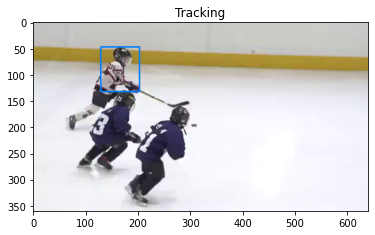

In [7]:
# Descomente a liña de abaixo para seleccionar unha caixa delimitadora diferente
# bbox = cv2.selectROI(frame, False)

# Inicia o rastreador co primeiro cadro e a caixa delimitadora
ok = tracker.init(frame, bbox)

# visualizamos a caixa
p1 = (int(bbox[0]), int(bbox[1]))
p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
cv2.rectangle(frame, p1, p2, blue, 2, 1 )

plt.imshow(frame[:,:,::-1])
plt.title("Tracking")

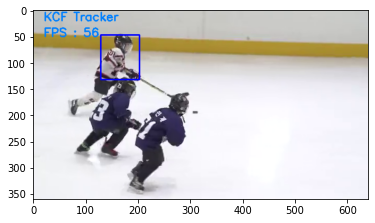

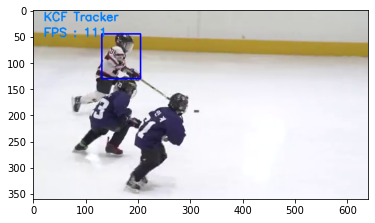

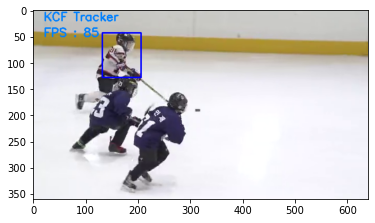

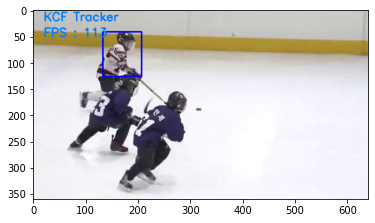

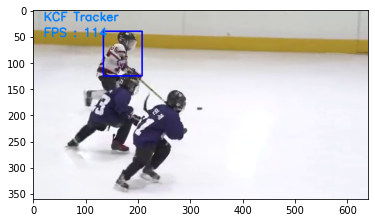

In [8]:
# Mostraremos só os 5 primeiros cadros
count = 0
while True:
    # Lemos os videos
    ok, frame = video.read()
    if not ok:
        break

    # iniciamos o tempo
    timer = cv2.getTickCount()
    
     # O método de actualización úsase para obter a localización
     # do novo obxecto rastrexado. O método volve
     # false cando se perde a pista. O seguimento pode fallar
     # porque o obxecto saíu fóra do cadro de vídeo ou
     # se o rastreador non puido rastrexar o obxecto.
     # En ambos casos, devólvese un valor falso.
    
     # Actualizar o rastreador
    ok, bbox = tracker.update(frame)
    
    # Calcula o tempo de procesamento e mostra os resultados.
    # Calcular fotogramas por segundo (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer);

    # debuxamos a caixa
    if ok:
      # Segumento exitoso
      p1 = (int(bbox[0]), int(bbox[1]))
      p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
      cv2.rectangle(frame, p1, p2, (255,0,0), 2, 1)
    else :
      # Fallo de seguimento
      cv2.putText(frame, "Fallo de seguimento detectado", (20,80), 
                  cv2.FONT_HERSHEY_SIMPLEX, 0.75,red,2)

    # Mostramos o nome do tracker
    cv2.putText(frame, tracker_type + " Tracker", (20,20), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.75, blue,2);
    
    # Mostramos os FPS na frame
    cv2.putText(frame, "FPS : " + str(int(fps)), (20,50), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.75, blue, 2);

    # Visualzamos
    plt.imshow(frame[:,:,::-1])
    plt.show()
    
    count += 1
    if count == 5:
        break

# <font style="color:rgb(50,120,229)">Combinando detección e seguimento</font>


Sorprendentemente, non hai forma de actualizar os resultados do seguimento mediante un algoritmo de detección mediante a clase de seguimento de OpenCV. Cabría esperar que os métodos **update** ou **init** ou un método completamente separado permitiran ao usuario proporcionar pistas ao rastreador mediante un detector. Non obstante, este non é o caso. A única forma de combinar os resultados do seguimento cun algoritmo de detección é iniciar un novo tracker mediante o método create.

# <font style="color:rgb(50,120,229)">Referencia e lecturas complementarias</font>

1. [http://www.vision.ee.ethz.ch/boostingTrackers/Grabner2006RealTimeTracking.pdf](http://www.vision.ee.ethz.ch/boostingTrackers/Grabner2006RealTimeTracking.pdf)

2. [http://vision.ucsd.edu/~bbabenko/new/project_miltrack.shtml](http://vision.ucsd.edu/~bbabenko/new/project_miltrack.shtml)

3. [https://arxiv.org/abs/1404.7584](https://arxiv.org/abs/1404.7584)

4. [http://kahlan.eps.surrey.ac.uk/featurespace/tld/Publications/2011_tpami](http://kahlan.eps.surrey.ac.uk/featurespace/tld/Publications/2011_tpami)

5. [http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.231.4285&rep=rep1&type=pdf](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.231.4285&rep=rep1&type=pdf)

6. [http://davheld.github.io/GOTURN/GOTURN.pdf](http://davheld.github.io/GOTURN/GOTURN.pdf)

7. [http://docs.opencv.org/trunk/d0/d0a/classcv_1_1Tracker.html](http://docs.opencv.org/trunk/d0/d0a/classcv_1_1Tracker.html)